In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")
import copy

import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
# from src.data import load_relation

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [3]:
import torch
import transformers
import baukit
from transformers import AutoModelForCausalLM, AutoTokenizer
from src.models import ModelandTokenizer

# state-spaces/mamba-2.8b | state-spaces/mamba-2.8b-slimpj
MODEL_PATH = "state-spaces/mamba-2.8b"  

mt = ModelandTokenizer(
    model_path=MODEL_PATH, 
    torch_dtype=torch.float32
)

2024-03-18 16:21:22 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2024-03-18 16:21:22 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /state-spaces/mamba-2.8b/resolve/main/config.json HTTP/1.1" 200 0
2024-03-18 16:21:33 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /state-spaces/mamba-2.8b/resolve/main/pytorch_model.bin HTTP/1.1" 302 0


/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


2024-03-18 16:21:36 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /EleutherAI/gpt-neox-20b/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-03-18 16:21:36 src.models INFO     loaded model <state-spaces/mamba-2.8b> | size: 10560.400 MB | dtype: torch.float32 | device: cuda


In [4]:
prompt_template = mt.tokenizer.eos_token + " {} is located in the city of"
subject = "Louvre"
alt_subject = "The Space Needle"

functional.predict_next_token(
    mt = mt,
    prompt = [
        prompt_template.format(subject),
        prompt_template.format(alt_subject),
    ]
)

[[PredictedToken(token=' Paris', prob=0.8302791714668274),
  PredictedToken(token='\n', prob=0.0442509688436985),
  PredictedToken(token=' Vers', prob=0.00933678075671196),
  PredictedToken(token=' France', prob=0.007960241287946701),
  PredictedToken(token=' L', prob=0.006667555775493383)],
 [PredictedToken(token=' Seattle', prob=0.9869956374168396),
  PredictedToken(token='\n', prob=0.003049238584935665),
  PredictedToken(token='  ', prob=0.0009398153051733971),
  PredictedToken(token=' downtown', prob=0.0008882731199264526),
  PredictedToken(token=' Tac', prob=0.0006469927611760795)]]

In [5]:
import copy
import json
import logging
import types
from collections import defaultdict
from typing import Literal, Optional, get_args

import baukit
import numpy
import torch
from tqdm import tqdm

import src.tokens as tokenizer_utils

# from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel as Mamba
from mamba_minimal.model import Mamba
from src import data, functional
from src.functional import (
    decode_tokens,
    find_token_range,
    make_inputs,
    predict_from_input,
)
from src.hooking.mamba import MambaBlock_Hook_Points, MambaBlockForwardPatcher
from src.models import ModelandTokenizer, is_mamba_variant

In [6]:
def path_ablation(
    mt,
    inp,  # A set of inputs
    residual_states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    uniform_noise=False,
    replace=False,  # True to replace with instead of add noise
    alt_subj_patching: bool = False,  # If True, will assume inp shape to be (2, L). Uncorrupted activations with inp[0] will be patched in the run with inp[1]. Will not corrupt the embeddings
    block_states_to_unpatch: (list) = [],  # A list of (token index, layername) triples to restore in the uncorrupted run
    hook_to_unpatch: Optional[
        MambaBlock_Hook_Points
    ] = None,
):
    assert is_mamba_variant(mt.model), "This function is only for Mamba models. check trace_with_repatch in the original implementation for other models"
    embed_layername = mt.embedder_name

    rs = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    if uniform_noise:
        prng = lambda *shape: rs.uniform(-1, 1, shape)
    else:
        prng = lambda *shape: rs.randn(*shape)

    residual_patch_spec = defaultdict(list)
    for t, l in residual_states_to_patch:
        residual_patch_spec[l].append(t)
    
    block_unpatch_spec = defaultdict(list)
    for t, l in block_states_to_unpatch:
        block_unpatch_spec[l].append(t)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    if isinstance(noise, float):
        noise_fn = lambda x: noise * x
    else:
        noise_fn = noise

    def patch_rep(repr, layer):
        assert first_run_residual_activations is not None

        if layer == embed_layername and alt_subj_patching == False:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                noise_data = noise_fn(
                    torch.from_numpy(prng(repr.shape[0] - 1, e - b, repr.shape[2]))
                ).to(repr.device)
                if replace:
                    repr[1:, b:e] = noise_data
                else:
                    repr[1:, b:e] += noise_data
            return repr
        
        if layer not in residual_patch_spec:
            return repr
        
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens from the first run
        h = untuple(repr)
        for t in residual_patch_spec[layer]:
            h[1:, t] = untuple(first_run_residual_activations[layer].output)[0, t]

        return repr

    mt.reset_forward()  # reset the model to use default forward functions

    # need to run twice to store corrupted and uncorrupted activations
    # of hooks inside the MambaBlock (Is there a better way?)
    interested_layers = list(set(
        list(residual_patch_spec.keys()) + list(block_unpatch_spec.keys())
    ))
    # print(f"{interested_layers=}")
    first_run_hook_activations = {layer: {} for layer in interested_layers}
    # print(f"{first_run_hook_activations.keys()=}")
    for layer in interested_layers:
        block = baukit.get_module(
            mt.model, name=layer + ".mixer"
        )  # MambaBlock naming format
        block.forward = types.MethodType(
            MambaBlockForwardPatcher(
                retainer=first_run_hook_activations[layer],
            ),  # get everything for the uncorrupted run
            block,
        )
    with torch.inference_mode(), baukit.TraceDict(
        mt.model,
        [embed_layername] + list(residual_patch_spec.keys()),
        edit_output = None # No intervention on the clean run
    ) as td:
        mt(**inp)

    first_run_residual_activations = td

    # print(f"{first_run_residual_activations.keys()=}")

    # ------------------------------------------------------
    # second run with patching / unpatching
    mt.reset_forward()  # reset the model to use default forward functions
    for layer in block_unpatch_spec:
        block = baukit.get_module(mt.model, name=layer + ".mixer")

        # restore the corrupted activations inside the MambaBlock here
        # the patching with clean residual states will be done in patch_rep
        cur_patch_spec = {
            token_idx: first_run_hook_activations[layer][hook_to_unpatch][1, t] # corrupted activations
            for token_idx in block_unpatch_spec[layer]
        }  
        block.forward = types.MethodType(
            MambaBlockForwardPatcher(
                patch_spec=cur_patch_spec,
                patch_hook=hook_to_unpatch,
            ),
            block,
        )
    with torch.inference_mode(), baukit.TraceDict(
        mt.model,
        [embed_layername] + list(residual_patch_spec.keys()), # make sure to patch from the clean activations
        edit_output=patch_rep,  # passing to patch_rep to noise the embeddings only. Restoring the states is done in the MambaBlockForwardPatcher forwards
    ):
        outputs_exp = mt.model(input_ids=inp["input_ids"])
    # ------------------------------------------------------
    mt.reset_forward()  # reset the model to use default forward functions

    # We report softmax probabilities for the answers_t token predictions of interest.
    logits = outputs_exp.logits if hasattr(outputs_exp, "logits") else outputs_exp
    probs = torch.softmax(logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    return probs

In [7]:
def trace_important_states_with_ablation(
    mt,
    inp,
    e_range,
    answer_t,
    noise=0.1,
    uniform_noise=False,
    replace=False,
    token_range=None,
    ablate_mambahook: Optional[MambaBlock_Hook_Points] = None,
    alt_subj_patching: bool = False,
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    if token_range is None:
        token_range = range(ntoks)

    for tnum in token_range:
        block_states_to_unpatch = []
        if ablate_mambahook is not None:
            block_states_to_unpatch = [
                (tnum, mt.layer_name_format.format(layer)) for layer in range(0, mt.n_layer)
            ]

        row = []
        for layer in range(mt.n_layer):
            r = path_ablation(
                mt = mt,
                inp = inp,
                residual_states_to_patch=[(tnum, mt.layer_name_format.format(layer))],
                answers_t=answer_t,
                tokens_to_mix=e_range,
                noise=noise,
                uniform_noise=uniform_noise,
                replace=replace,
                block_states_to_unpatch=block_states_to_unpatch,
                hook_to_unpatch=ablate_mambahook,
                alt_subj_patching=alt_subj_patching,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

In [8]:
from src.tracing import trace_with_patch, replace_eos_with_pad

def calculate_hidden_flow_with_ablation(
    mt: ModelandTokenizer,
    prompt: str,
    subject: str,
    alt_subject: Optional[str] = None,
    num_samples=10,
    noise=0.1,
    token_range=None,
    uniform_noise=False,
    replace=False,
    window=10,
    ablate_mambahook: Optional[MambaBlock_Hook_Points] = None,
):
    if alt_subject is None:
        inp = make_inputs(mt.tokenizer, [prompt] * (num_samples + 1))
        with torch.no_grad():
            answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
        e_range = find_token_range(
            string=prompt,
            substring=subject,
            tokenizer=mt.tokenizer,
        )
        low_score = trace_with_patch(
            mt,
            inp,
            [],
            answer_t,
            e_range,
            noise=noise,
            uniform_noise=uniform_noise,
            mamba_block_hook=None,  # don't need to patch for calculating the low score
            alt_subj_patching=alt_subject is not None,
        ).item()
    else:
        if "{}" in prompt:
            prompt = prompt.format(subject)
        clean_prompt = prompt
        alt_prompt = prompt.replace(subject, alt_subject)
        with tokenizer_utils.set_padding_side(mt.tokenizer, padding_side="left"):
            inp = mt.tokenizer(
                [clean_prompt, alt_prompt],
                return_tensors="pt",
                padding="longest",
                return_offsets_mapping=True,
            ).to(mt.device)
        offset_mapping = inp.pop("offset_mapping")
        subject_range = find_token_range(
            string=clean_prompt,
            substring=subject,
            tokenizer=mt.tokenizer,
            offset_mapping=offset_mapping[0],
        )
        alt_subj_range = find_token_range(
            string=alt_prompt,
            substring=alt_subject,
            tokenizer=mt.tokenizer,
            offset_mapping=offset_mapping[1],
        )
        assert subject_range[1] == alt_subj_range[1]
        e_range = (min(subject_range[0], alt_subj_range[0]), subject_range[1])

        with torch.no_grad():
            outputs = mt(**inp)
        logits = outputs.logits[:, -1] if hasattr(outputs, "logits") else outputs[:, -1]
        next_token_probs = logits.float().softmax(dim=-1)
        answer_t = next_token_probs[0].argmax(dim=-1)
        base_score = next_token_probs[0, answer_t]  # p(ans|subj)
        low_score = next_token_probs[1, answer_t]  # p(ans|alt_subj)
    
    
    if token_range == "subject_last":
        token_range = [e_range[1] - 1]
    elif token_range is not None:
        raise ValueError(f"Unknown token_range: {token_range}")

    
    [answer] = decode_tokens(mt.tokenizer, [answer_t])

    differences = trace_important_states_with_ablation(
        mt =  mt,
        inp =  inp,
        e_range = e_range,
        answer_t = answer_t,
        noise = noise,
        uniform_noise = uniform_noise,
        replace = replace,
        token_range = token_range,
        ablate_mambahook = ablate_mambahook,
        alt_subj_patching=alt_subject is not None,
    )

    differences = differences.detach().cpu()
    indirect_effect = dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=replace_eos_with_pad(
            mt.tokenizer, list(decode_tokens(mt.tokenizer, inp["input_ids"][0]))
        ),
        subject_range=e_range,
        answer=answer,
        window=window,
        correct_prediction=True,
        kind=ablate_mambahook,
    )

    if alt_subject is not None:
        indirect_effect["alt_subject"] = replace_eos_with_pad(
            mt.tokenizer,
            list(
                decode_tokens(
                    mt.tokenizer, inp["input_ids"][1, e_range[0] : e_range[1]]
                )
            ),
        )

    return indirect_effect


In [9]:
# from src.plotting import plot_trace_heatmap

# indirect_effect = calculate_hidden_flow_with_ablation(
#     mt = mt,
#     prompt = prompt_template,
#     subject = subject,
#     alt_subject = alt_subject,
#     num_samples = 10,
#     noise = 0.1,
#     token_range = None,
#     uniform_noise = False,
#     replace = False,
#     window = 10,
#     ablate_mambahook = None,
# )

# plot_trace_heatmap(indirect_effect, modelname=MODEL_PATH.split("/")[-1])

In [10]:
# indirect_effect_ablate_ssm = calculate_hidden_flow_with_ablation(
#     mt = mt,
#     prompt = prompt_template,
#     subject = subject,
#     alt_subject = alt_subject,
#     num_samples = 10,
#     noise = 0.1,
#     token_range = None,
#     uniform_noise = False,
#     replace = False,
#     window = 10,
#     ablate_mambahook = "ssm_after_ssm",
# )
# plot_trace_heatmap(indirect_effect_ablate_ssm, modelname=MODEL_PATH.split("/")[-1])

In [11]:
# indirect_effect_ablate_other = calculate_hidden_flow_with_ablation(
#     mt = mt,
#     prompt = prompt_template,
#     subject = subject,
#     alt_subject = alt_subject,
#     num_samples = 10,
#     noise = 0.1,
#     token_range = None,
#     uniform_noise = False,
#     replace = False,
#     window = 10,
#     ablate_mambahook = "mlp_after_silu",
# )
# plot_trace_heatmap(indirect_effect_ablate_other, modelname=MODEL_PATH.split("/")[-1])

In [25]:
kwargs = dict(
    mt = mt,
    prompt = prompt_template,
    subject = subject,
    alt_subject = alt_subject,
    num_samples = 10,
    noise = 0.1,
    token_range = "subject_last",
    uniform_noise = False,
    replace = False,
    window = 10,
)

indirect_effect = calculate_hidden_flow_with_ablation(
    ablate_mambahook=None,
    **kwargs,
)

indirect_effect_ssm_severed = calculate_hidden_flow_with_ablation(
    ablate_mambahook="ssm_after_ssm",
    **kwargs,
)

indirect_effect_mlp_severed = calculate_hidden_flow_with_ablation(
    ablate_mambahook="mlp_after_silu",
    **kwargs,
)

high_score = indirect_effect["high_score"].item()
low_score = indirect_effect["low_score"].item()

ie = (indirect_effect["scores"] - low_score) / (high_score - low_score)
ie_ssm_severed = (indirect_effect_ssm_severed["scores"] - low_score) / (high_score - low_score)
ie_mlp_severed = (indirect_effect_mlp_severed["scores"] - low_score) / (high_score - low_score)

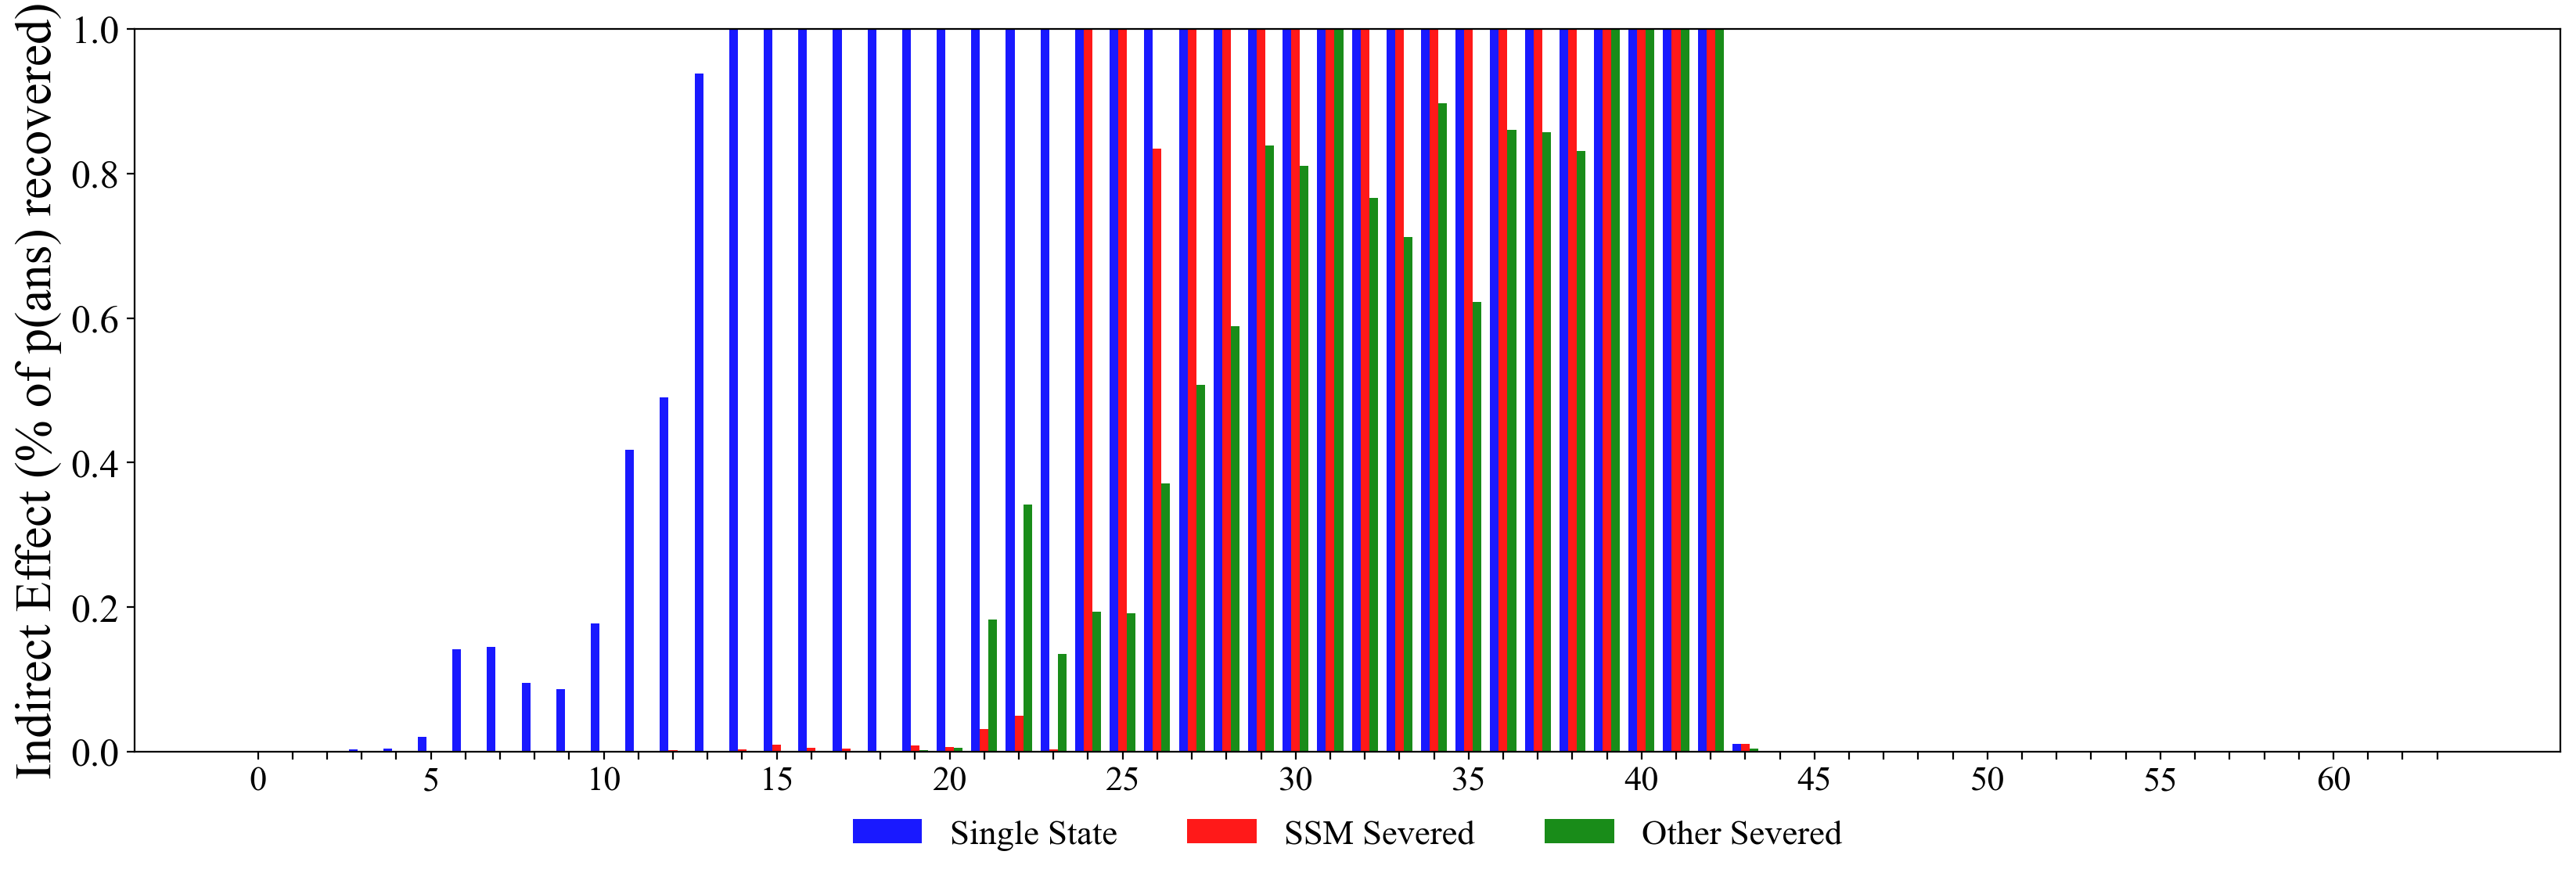

In [26]:
import matplotlib.pyplot as plt
import numpy as np

#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE+5)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

def plot_aie_subject_last(
    indirect_effects,
    indirect_effects_with_ssm_severed,
    indirect_effects_with_mlp_severed,
):
    state_indirect_effects = {
        "Single State": indirect_effects.squeeze().numpy(),
        "SSM Severed": indirect_effects_with_ssm_severed.squeeze().numpy(),
        "Other Severed": indirect_effects_with_mlp_severed.squeeze().numpy(),
    }
    config_color = {
        "Single State": "blue",
        "SSM Severed": "red",
        "Other Severed": "green",
    }

    # plt.rcdefaults()
    plt.figure(figsize=(20, 6))

    idx = 0
    bar_width = 0.25
    for config in state_indirect_effects:
        plot_ie = []
        for layer in range(mt.n_layer):
            plot_ie.append(state_indirect_effects[config][layer])
        
        plt.bar(
            np.arange(len(plot_ie)) + idx * bar_width, plot_ie,
            width = bar_width,
            label = config,
            # edgecolor = "black",
            color = config_color[config],
            alpha = 0.9
        )
        idx += 1

    def layer_tick(layer_idx, jump=5):
        return f"{layer_idx}" if layer_idx % jump == 0 else ""

    plt.ylim(0, 1)
    plt.xticks(
        np.arange(mt.n_layer) + bar_width, 
        [layer_tick(i) for i in range(mt.n_layer)]
    )
    
    ylabel = f"Indirect Effect ({'%'} of p(ans) recovered)"

    plt.ylabel(ylabel)
    plt.legend(ncol = 3, bbox_to_anchor=(0.5, -.18), loc='lower center', frameon=False)
    # plt.savefig(f"figs/faithfulness_lre_models.pdf", bbox_inches="tight")
    plt.show()


plot_aie_subject_last(ie, ie_ssm_severed, ie_mlp_severed)

In [28]:
# from src.data.dataclasses import CounterFactDataset

from src.data.dataclasses import load_relation
relation = load_relation(file = "../data/relation/factual/place_in_city.json")

2024-03-18 16:41:05 src.data.dataclasses INFO     initialized relation -> "place in city" with 154 samples


In [29]:
question, answer = relation[10]
print(question, end="\n\n")
print(f"{answer=}")

Milford Sound is located in the city of South Island
Kilimanjaro is located in the city of Region
Rainbow Bridge is located in the city of Tokyo
Nasca Lines is located in the city of Nasca
Niagara Falls is located in the city of Niagara Falls
Big Sur is located in the city of

answer='California'


In [30]:
from src.functional import filter_samples_by_model_knowledge
relation = filter_samples_by_model_knowledge(
    mt = mt,
    relation = relation,
)

2024-03-18 16:41:07 src.functional DEBUG    "place in city" | filtering with state-spaces/mamba-2.8b


2024-03-18 16:41:07 src.functional DEBUG    sample.subject='Angkor Wat' -> answer='Siem Reap' | predicted = ' Ang'(0.388) ==> (✗)
2024-03-18 16:41:07 src.functional DEBUG    sample.subject='Yosemite National Park' -> answer='California' | predicted = ' Y'(0.518) ==> (✗)
2024-03-18 16:41:07 src.functional DEBUG    sample.subject='Carnival of Rio de Janeiro' -> answer='Rio de Janeiro' | predicted = ' Rio'(0.928) ==> (✓)
2024-03-18 16:41:08 src.functional DEBUG    sample.subject='La Sagrada Familia' -> answer='Barcelona' | predicted = ' Barcelona'(0.855) ==> (✓)
2024-03-18 16:41:08 src.functional DEBUG    sample.subject='Casa Mila' -> answer='Barcelona' | predicted = ' Barcelona'(0.760) ==> (✓)
2024-03-18 16:41:08 src.functional DEBUG    sample.subject='Times Square' -> answer='New York' | predicted = ' New'(0.718) ==> (✓)
2024-03-18 16:41:08 src.functional DEBUG    sample.subject='Colosseum' -> answer='Rome' | predicted = ' Rome'(0.916) ==> (✓)
2024-03-18 16:41:09 src.functional DEBUG   

In [31]:
# -------------------------------------------------
n_trials = 30
# -------------------------------------------------

samples = relation.samples[: n_trials]
edit_targets = functional.random_edit_targets(samples = samples)

In [33]:
from tqdm.auto import tqdm

common_kwargs = dict(
    mt = mt,
    prompt = relation.prompt_templates[0],
    token_range = "subject_last",
    window = 6,
)

all_indirect_effects = []
all_indirect_effects_ssm_severed = []
all_indirect_effects_mlp_severed = []

for sample in tqdm(samples):
    alt_sample = edit_targets[sample]

    print(f"sample={str(sample)}, alt_sample={str(alt_sample)}")

    indirect_effect = calculate_hidden_flow_with_ablation(
        subject = sample.subject,
        alt_subject = alt_sample.subject,
        ablate_mambahook=None,
        **common_kwargs,
    )

    indirect_effect_ssm_severed = calculate_hidden_flow_with_ablation(
        subject = sample.subject,
        alt_subject = alt_subject,
        ablate_mambahook="ssm_after_ssm",
        **common_kwargs,
    )

    indirect_effect_mlp_severed = calculate_hidden_flow_with_ablation(
        subject = sample.subject,
        alt_subject = alt_subject,
        ablate_mambahook="mlp_after_silu",
        **common_kwargs,
    )

    high_score = indirect_effect["high_score"].item()
    low_score = indirect_effect["low_score"].item()

    ie = (indirect_effect["scores"] - low_score) / (high_score - low_score)
    ie_ssm_severed = (indirect_effect_ssm_severed["scores"] - low_score) / (high_score - low_score)
    ie_mlp_severed = (indirect_effect_mlp_severed["scores"] - low_score) / (high_score - low_score)

    all_indirect_effects.append(ie)
    all_indirect_effects_ssm_severed.append(ie_ssm_severed)
    all_indirect_effects_mlp_severed.append(ie_mlp_severed)


  0%|          | 0/30 [00:00<?, ?it/s]

sample=Carnival of Rio de Janeiro -> Rio de Janeiro, alt_sample=Casa Mila -> Barcelona
sample=La Sagrada Familia -> Barcelona, alt_sample=Royal Palace of Madrid -> Madrid
sample=Casa Mila -> Barcelona, alt_sample=Meenakshi Amman Temple -> Madurai
sample=Times Square -> New York, alt_sample=Torres del Paine -> Torres del Paine
sample=Colosseum -> Rome, alt_sample=Sultan Ahmed Mosque -> Istanbul
sample=Old Havana -> Havana, alt_sample=Versailles -> Versailles
sample=Brandenburg Gate -> Berlin, alt_sample=Eiffel Tower -> Paris
sample=Santorini -> Santorini, alt_sample=Lincoln Memorial -> Washington D.C.
sample=Vasa Museum -> Stockholm, alt_sample=Brandenburg Gate -> Berlin
sample=Space Needle -> Seattle, alt_sample=Meenakshi Amman Temple -> Madurai
sample=Capitol Hill -> Washington D.C., alt_sample=Louvre -> Paris
sample=British Museum -> London, alt_sample=Times Square -> New York
sample=Sukhothai Historical Park -> Sukhothai, alt_sample=Kremlin and Red Square -> Moscow
sample=Meenakshi 

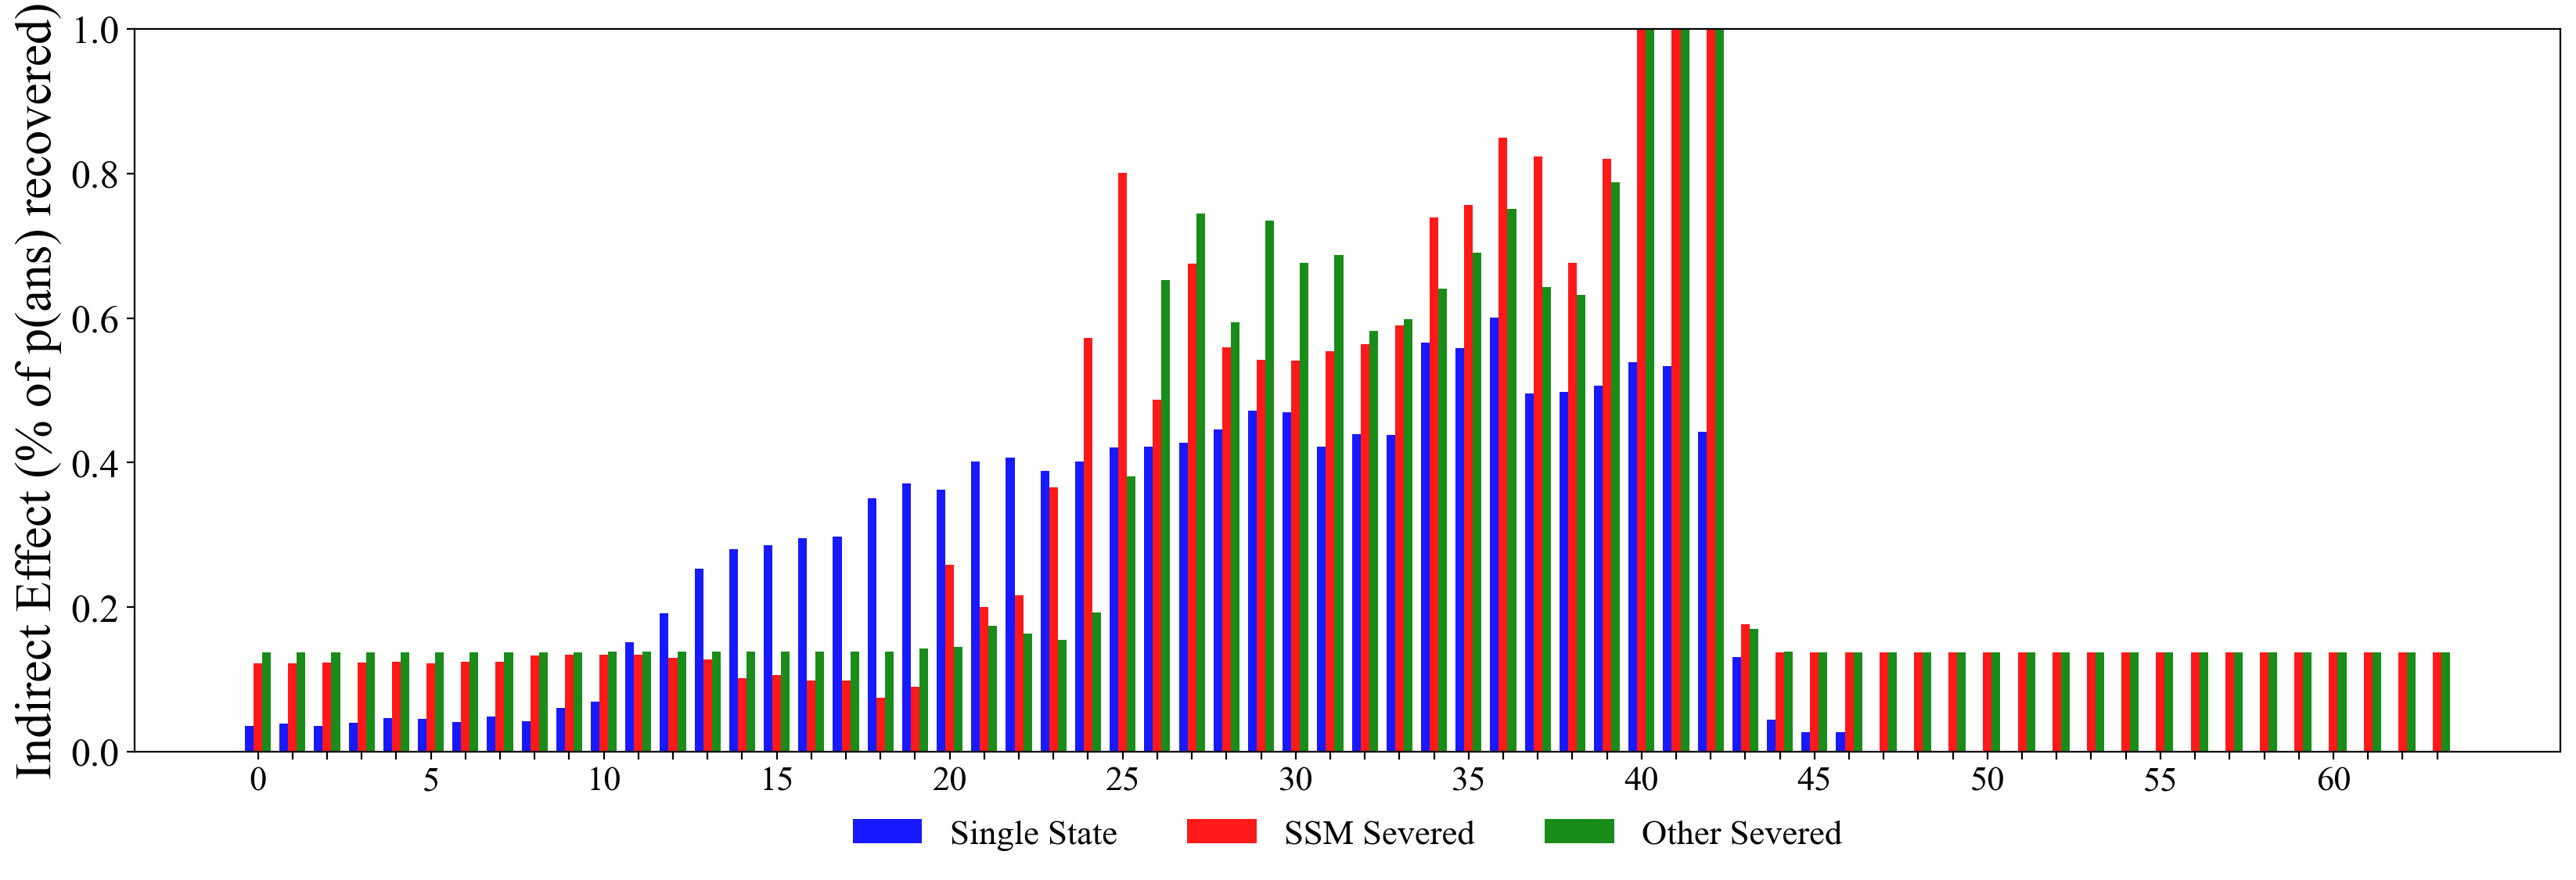

In [34]:
avg_indirect_effects = torch.stack(all_indirect_effects).squeeze().mean(dim=0)
avg_indirect_effects_ssm_severed = torch.stack(all_indirect_effects_ssm_severed).squeeze().mean(dim=0)
avg_indirect_effects_mlp_severed = torch.stack(all_indirect_effects_mlp_severed).squeeze().mean(dim=0)

plot_aie_subject_last(
    avg_indirect_effects, 
    avg_indirect_effects_ssm_severed, 
    avg_indirect_effects_mlp_severed
)